In [1]:
import scanpy as sc
import anndata
import pandas as pd
import SM2ST as SM2ST
import STMGraph_pyG0
# import SMLED_pyG1 as SMLED
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import pearsonr
os.environ['R_HOME'] = '/home/llx/software/miniconda3/envs/pyg_ms/lib/R'

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# df_ms=pd.read_csv('/home/llx/project/jupyternotebook/1_pyg_backup/Data/MSD/mouse_brain_pen_dhb_50um_pixel_intensities.csv', skiprows=2,index_col=0)
# df_ms=pd.read_csv('/home/llx/project/MSI_data/mouse_pen_50um/mouse_pen_50um.csv',index_col=0)
df_ms=pd.read_csv('/home/llx/project/MSI_data/mouse_ito_30um/ito_30um_mad.csv',index_col=0)
df_ms

x121_y1     x122_y1     x123_y1     x124_y1     x120_y2  \
152.020966     0.000000    0.000000    0.000000    0.000000    0.000000   
152.055574     0.000000    0.000000    0.000000    0.000000    0.000000   
154.024702   168.884988  173.589709  178.140641    0.000000  174.022542   
155.032674   914.838941  841.292449  685.393545  677.771875  864.347548   
156.039791   175.582464    0.000000    0.000000    0.000000  173.381969   
...                 ...         ...         ...         ...         ...   
1002.575657    0.000000    0.000000    0.000000    0.000000    0.000000   
1003.580487    0.000000    0.000000    0.000000    0.000000    0.000000   
1006.491884    0.000000    0.000000    0.000000    0.000000    0.000000   
1020.533017    0.000000    0.000000    0.000000    0.000000    0.000000   
1024.560133    0.000000    0.000000    0.000000    0.000000    0.000000   

                x121_y2    x122_y2     x123_y2    x124_y2     x125_y2  ...  \
152.020966     0.000000    0.00000    0.000000    0.00000    0.000000  ...   
152.055574     0.000000    0.00000    0.000000    0.00000    0.000000  ...   
154.024702     0.000000    0.00000    0.000000    0.00000    0.000000  ...   
155.032674   605.742957  471.56691  575.327534  615.13367  478.488232  ...   
156.039791     0.000000    0.00000    0.000000    0.00000    0.000000  ...   
...                 ...        ...         ...        ...         ...  ...   
1002.575657    0.000000    0.00000    0.000000    0.00000    0.000000  ...   
1003.580487    0.000000    0.00000    0.000000    0.00000    0.000000  ...   
1006.491884    0.000000    0.00000    0.000000    0.00000    0.000000  ...   
1020.533017    0.000000    0.00000    0.000000    0.00000    0.000000  ...   
1024.560133    0.000000    0.00000    0.000000    0.00000    0.000000  ...   

             x19_y180  x20_y180  x21_y180  x22_y180  x23_y180  x24_y180  \
152.020966        0.0       0.0       0.0       0.0       0.0       0.0   
152.055574        0.0       0.0       0.0       0.0       0.0       0.0   
154.024702        0.0       0.0       0.0       0.0       0.0       0.0   
155.032674        0.0       0.0       0.0       0.0       0.0       0.0   
156.039791        0.0       0.0       0.0       0.0       0.0       0.0   
...               ...       ...       ...       ...       ...       ...   
1002.575657       0.0       0.0       0.0       0.0       0.0       0.0   
1003.580487       0.0       0.0       0.0       0.0       0.0       0.0   
1006.491884       0.0       0.0       0.0       0.0       0.0       0.0   
1020.533017       0.0       0.0       0.0       0.0       0.0       0.0   
1024.560133       0.0       0.0       0.0       0.0       0.0       0.0   

             x25_y180    x12_y181   x13_y181    x14_y181  
152.020966        0.0    0.000000    0.00000    0.000000  
152.055574        0.0    0.000000    0.00000    0.000000  
154.024702        0.0  141.996522    0.00000  152.399847  
155.032674        0.0  474.338544  443.96218  673.394671  
156.039791        0.0    0.000000    0.00000    0.000000  
...               ...         ...        ...         ...  
1002.575657       0.0    0.000000    0.00000    0.000000  
1003.580487       0.0    0.000000    0.00000    0.000000  
1006.491884       0.0    0.000000    0.00000    0.000000  
1020.533017       0.0    0.000000    0.00000    0.000000  
1024.560133       0.0    0.000000    0.00000    0.000000  

[1389 rows x 27541 columns]

In [9]:
def create_anndata_or(dataframe=None,pixel_size=1):
    
    df_ms_new=dataframe.iloc[:,:].T#4
    # 检查每一行是否所有元素都是0
    rows_all_zero = (df_ms_new == 0).all(axis=1)

    # 使用布尔索引删除所有元素都是0的行
    df_ms_new = df_ms_new[~rows_all_zero]
    df_ms_new = df_ms_new.apply(lambda x: x - x.min(), axis=0)
    # 收集所有坐标到列表中
    rows = []
    cols = []
    for name in df_ms_new.index:
        x, y = name.split('_y')
        rows.append(int(x[1:]))
        cols.append(int(y))

    # 使用列表一次性创建DataFrame
    coordinates_df = pd.DataFrame({'array_row': rows, 'array_col': cols})
    coordinates_df.index = df_ms_new.index
    coordinates_physical_df = coordinates_df*pixel_size
    # 初始化 AnnData 对象
    index_df = pd.DataFrame(index=dataframe.index)
    adata = anndata.AnnData(X=df_ms_new.values, obs=coordinates_df, var=index_df)#4
    adata.obsm['spatial'] = coordinates_physical_df.values
    return adata

In [10]:
adata = create_anndata_or(dataframe=df_ms,pixel_size=30)

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
adata.obsm['spatial']

array([[3630,   30],
       [3660,   30],
       [3690,   30],
       ...,
       [ 360, 5430],
       [ 390, 5430],
       [ 420, 5430]])

In [17]:
adata.var

Empty DataFrame
Columns: []
Index: [152.020965924914, 152.055573563462, 154.02470188454, 155.032674264227, 156.039791285186, 156.076763865438, 156.884284711508, 158.082694571309, 159.004315981006, 159.026728883998, 159.090165568164, 160.132196863264, 161.132966278513, 162.111654727668, 162.954984071184, 163.114857823647, 166.061667426842, 167.065287992255, 170.031771751788, 170.095235845783, 172.029913132307, 174.894966181399, 174.978257538114, 175.000574761835, 175.117969581489, 176.007229584542, 177.014987608149, 178.048904254412, 180.064553249124, 180.903010089818, 181.048602137676, 181.068002652673, 184.071739429971, 184.088261823187, 184.185628422554, 184.453094417095, 185.075777658643, 185.947126690555, 185.958833887429, 186.076829708865, 186.955028457582, 189.159221256983, 190.910807761785, 191.980989153054, 192.013560603724, 192.980206300488, 196.059407548089, 196.87675264614, 197.989334028124, 198.088593810617, 198.875187849963, 198.99650159857, 199.091337307002, 200.067577258414, 200.088789372543, 200.910730998633, 201.932876927742, 202.935121144479, 202.986148770676, 203.051824389371, 203.222134074202, 203.930363519779, 204.121978660403, 206.054467992933, 207.013427209064, 207.058127051938, 207.987589405159, 212.851379095398, 212.955482563445, 213.963426690753, 214.849104942436, 214.971261953888, 215.96162077733, 215.974323387042, 216.969149771106, 217.048835865906, 217.93725955335, 218.056558642768, 221.018139915006, 222.028410778009, 222.088012423921, 222.987420004387, 223.031886243247, 223.971348941985, 224.026791999805, 224.103166982841, 225.10577869487, 226.082898590608, 227.033049043737, 228.040519624895, 228.929435114254, 229.048793262252, 229.936998086853, 230.05256585219, 230.944073369875, 231.935234735181, 231.948429802712, 232.943357012985, 233.947078361936, 235.944991146424, ...]

[1389 rows x 0 columns]

<Axes: title={'center': '152.055573563462'}, xlabel='spatial1', ylabel='spatial2'>

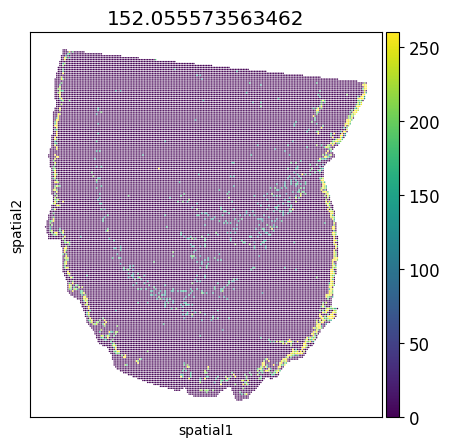

In [20]:
plot_gene = '152.055573563462'#C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # 例如，figsize=(10, 8) 表示宽度为
plt.rcParams['font.size'] = 12  # 假设默认字体大小是10
sc.pl.embedding(adata, basis="spatial", color=plot_gene, show=False,vmax='p99', ax=ax)

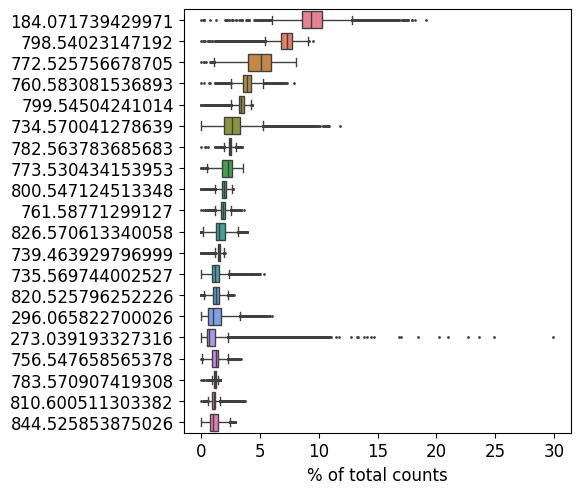

In [21]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [29]:
def anndata_transfer_resolution2(adata=None,pixel_size=1):
    original_coordinates = adata.obsm['spatial'].copy()
    new_coordinates_1 = adata.obsm['spatial'].copy()
    new_coordinates_1[:,1] =  new_coordinates_1[:,1] + pixel_size//2
    new_adata_1=adata.copy()
    # 将矩阵除以25
    divided_new_coordinates_1 = new_coordinates_1 // (pixel_size//2)
    # 创建一个DataFrame，列名设置为 'array_row' 和 'array_col'
    df_divided_new_coordinates_1 = pd.DataFrame(divided_new_coordinates_1, columns=['array_row', 'array_col'])
    new_adata_1.obs = df_divided_new_coordinates_1
    new_adata_1.obsm['spatial'] = new_coordinates_1
    adata_combined_1 = sc.concat([adata, new_adata_1], axis=0, join='outer', uns_merge='unique')
    
    new_coordinates_2 = adata_combined_1.obsm['spatial'].copy()
    new_coordinates_2 = new_coordinates_2.copy()
    new_coordinates_2[:,0] =  new_coordinates_2[:,0] + pixel_size//2
    new_adata_2=adata_combined_1.copy()
    # 将矩阵除以25
    divided_new_coordinates_2 = new_coordinates_2 // (pixel_size//2)
    # 创建一个DataFrame，列名设置为 'array_row' 和 'array_col'
    df_divided_new_coordinates_2 = pd.DataFrame(divided_new_coordinates_2, columns=['array_row', 'array_col'])
    new_adata_2.obs = df_divided_new_coordinates_2
    new_adata_2.obsm['spatial'] = new_coordinates_2
    adata_combined_2 = sc.concat([adata_combined_1, new_adata_2], axis=0, join='outer', uns_merge='unique')
    # 重置 .obs DataFrame 的索引，从0开始
    adata_combined_2.obs = adata_combined_2.obs.reset_index(drop=True)
    adata_combined_2.obs_names = adata_combined_2.obs_names.astype(str)
    return adata_combined_2

In [30]:
new_adata = anndata_transfer_resolution2(adata=adata,pixel_size=30)

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [31]:
new_adata.obsm['spatial']

array([[3630,   30],
       [3660,   30],
       [3690,   30],
       ...,
       [ 375, 5445],
       [ 405, 5445],
       [ 435, 5445]])

In [32]:
new_adata.obsm['spatial'].shape

(110164, 2)

In [33]:
new_adata.obs

array_row  array_col
0             121          1
1             122          1
2             123          1
3             124          1
4             120          2
...           ...        ...
110159         49        361
110160         51        361
110161         25        363
110162         27        363
110163         29        363

[110164 rows x 2 columns]

<Axes: title={'center': '152.055573563462'}, xlabel='spatial1', ylabel='spatial2'>

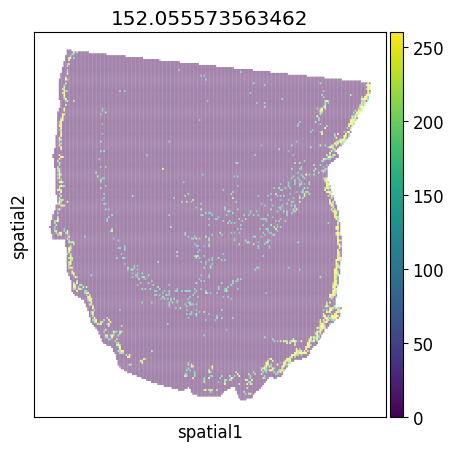

In [34]:
plot_gene = '152.055573563462'
fig, ax = plt.subplots(figsize=(5, 5))  # 例如，figsize=(10, 8) 表示宽度为
plt.rcParams['font.size'] = 12  # 假设默认字体大小是10
sc.pl.embedding(new_adata, basis="spatial", color=plot_gene, show=False,vmax='p99', ax=ax)

In [35]:
sc.pp.normalize_total(new_adata, target_sum=1e4)
sc.pp.log1p(new_adata)

<Axes: title={'center': '152.055573563462'}, xlabel='spatial1', ylabel='spatial2'>

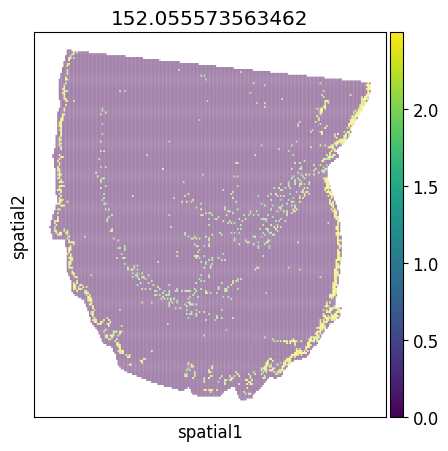

In [36]:
plot_gene = '152.055573563462'
fig, ax = plt.subplots(figsize=(5, 5))  # 例如，figsize=(10, 8) 表示宽度为
plt.rcParams['font.size'] = 12  # 假设默认字体大小是10
sc.pl.embedding(new_adata, basis="spatial", color=plot_gene, show=False,vmax='p99', ax=ax)

In [37]:
# grid setting
num_batch_x = 3
num_batch_y = 2
new_adata.obs['x'] = new_adata.obsm['spatial'][:,0]
new_adata.obs['y'] = new_adata.obsm['spatial'][:,1]

In [38]:
import seaborn as sns
def Batch_Data(adata, num_batch_x, num_batch_y, spatial_key=['X', 'Y'], plot_Stats=False):
    Sp_df = adata.obs.loc[:, spatial_key].copy()
    Sp_df = np.array(Sp_df)
    batch_x_coor_1 = [np.percentile(Sp_df[:, 0], (1/num_batch_x)*x*100) for x in range(num_batch_x+1)]
    batch_y_coor_1 = [np.percentile(Sp_df[:, 1], (1/num_batch_y)*x*100) for x in range(num_batch_y+1)]
    batch_x_coor_2 = [np.percentile(Sp_df[:, 0], (1/(num_batch_x*2))*x*100) for x in range(1,num_batch_x*2+1,2)]
    batch_y_coor_2 = [np.percentile(Sp_df[:, 1], (1/(num_batch_y*2))*x*100) for x in range(1,num_batch_y*2+1,2)]
    
    Batch_list = []
    for it_x in range(num_batch_x):
        for it_y in range(num_batch_y):
            min_x_1 = batch_x_coor_1[it_x]
            max_x_1 = batch_x_coor_1[it_x+1]
            min_y_1 = batch_y_coor_1[it_y]
            max_y_1 = batch_y_coor_1[it_y+1]
            temp_adata = adata.copy()
            temp_adata = temp_adata[temp_adata.obs[spatial_key[0]].map(lambda x: min_x_1 <= x <= max_x_1)]
            temp_adata = temp_adata[temp_adata.obs[spatial_key[1]].map(lambda y: min_y_1 <= y <= max_y_1)]
            Batch_list.append(temp_adata)
    
    for it_x in range(num_batch_x-1):
        for it_y in range(num_batch_y-1):
            min_x_2 = batch_x_coor_2[it_x]
            max_x_2 = batch_x_coor_2[it_x+1]
            min_y_2 = batch_y_coor_2[it_y]
            max_y_2 = batch_y_coor_2[it_y+1]
            temp_adata = adata.copy()
            temp_adata = temp_adata[temp_adata.obs[spatial_key[0]].map(lambda x: min_x_2 <= x <= max_x_2)]
            temp_adata = temp_adata[temp_adata.obs[spatial_key[1]].map(lambda y: min_y_2 <= y <= max_y_2)]
            Batch_list.append(temp_adata)
    
    for it_x in range(num_batch_x-1):
        for it_y in range(num_batch_y):
            min_x_2 = batch_x_coor_2[it_x]
            max_x_2 = batch_x_coor_2[it_x+1]
            min_y_1 = batch_y_coor_1[it_y]
            max_y_1 = batch_y_coor_1[it_y+1]
            temp_adata = adata.copy()
            temp_adata = temp_adata[temp_adata.obs[spatial_key[0]].map(lambda x: min_x_2 <= x <= max_x_2)]
            temp_adata = temp_adata[temp_adata.obs[spatial_key[1]].map(lambda y: min_y_1 <= y <= max_y_1)]
            Batch_list.append(temp_adata)
    
    for it_x in range(num_batch_x):
        for it_y in range(num_batch_y-1):
            min_x_1 = batch_x_coor_1[it_x]
            max_x_1 = batch_x_coor_1[it_x+1]
            min_y_2 = batch_y_coor_2[it_y]
            max_y_2 = batch_y_coor_2[it_y+1]
            temp_adata = adata.copy()
            temp_adata = temp_adata[temp_adata.obs[spatial_key[0]].map(lambda x: min_x_1 <= x <= max_x_1)]
            temp_adata = temp_adata[temp_adata.obs[spatial_key[1]].map(lambda y: min_y_2 <= y <= max_y_2)]
            Batch_list.append(temp_adata)
    if plot_Stats:
        f, ax = plt.subplots(figsize=(1, 3))
        plot_df = pd.DataFrame([x.shape[0] for x in Batch_list], columns=['#spot/batch'])
        sns.boxplot(y='#spot/batch', data=plot_df, ax=ax)
        sns.stripplot(y='#spot/batch', data=plot_df, ax=ax, color='red', size=5)
    return Batch_list

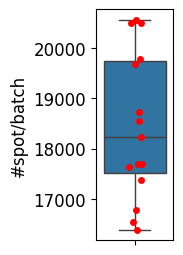

In [39]:
Batch_list_1 = Batch_Data(new_adata, num_batch_x=num_batch_x, num_batch_y=num_batch_y,spatial_key=['x', 'y'], plot_Stats=True)

In [40]:
# Consturcting network for each batch
for temp_adata in Batch_list_1:
    STMGraph_pyG0.Cal_Spatial_Net(temp_adata, model='KNN', k_cutoff=8, delta_err=0.05)
    #STAGATE_pyG.Stats_Spatial_Net(temp_adata)

------Calculating spatial graph...
The graph contains 129306 edges, 16389 cells.
7.8898 neighbors per cell on average.


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


------Calculating spatial graph...
The graph contains 162700 edges, 20562 cells.
7.9127 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 162110 edges, 20498 cells.
7.9086 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 132710 edges, 16788 cells.
7.9051 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 147994 edges, 18733 cells.
7.9002 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 143994 edges, 18232 cells.
7.8979 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 139952 edges, 17696 cells.
7.9087 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 139952 edges, 17696 cells.
7.9087 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 155710 edges, 19688 cells.
7.9089 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 139458 edges, 17636 cells.
7.9076 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 162034 edges, 20486 cells.
7.9095 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 130798 edges, 16546 cells.
7.9051 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 156456 edges, 19778 cells.
7.9106 neighbors per cell on average.


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


------Calculating spatial graph...
The graph contains 137436 edges, 17380 cells.
7.9077 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 146516 edges, 18542 cells.
7.9018 neighbors per cell on average.


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


In [41]:
STMGraph_pyG0.Cal_Spatial_Net(new_adata, model='KNN', k_cutoff=8, delta_err=0.05)
adata_om1 = STMGraph_pyG0.Transfer_pytorch_Data(new_adata)

------Calculating spatial graph...
The graph contains 876748 edges, 110164 cells.
7.9586 neighbors per cell on average.


In [42]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data_list1 = [STMGraph_pyG0.Transfer_pytorch_Data(temp_adata) for temp_adata in Batch_list_1]
for temp in data_list1:
    temp.to(device)

In [43]:
import random
import torch.backends.cudnn as cudnn

def fix_seed(seed):
    #seed = 2023
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False
    
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  

In [44]:
from torch_geometric.loader import DataLoader

# hyper-parameters
num_epoch = 1000
lr=0.001
weight_decay=1e-4
hidden_dims = [512, 30]
alpha = 1
mask_ratio = 0.5
noise = 0.0
gradient_clipping = 5.

import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm

def sce_loss(x, y, alpha=1.0):
    x = F.normalize(x, p=2, dim=-1)
    y = F.normalize(y, p=2, dim=-1)
    loss = (1 - (x * y).sum(dim=-1)).pow_(alpha)

    loss = loss.mean()
    return loss
seed=2025
fix_seed(seed)
# batch_size=1 or 2
loader = DataLoader(data_list1, batch_size=1, shuffle=True)
model = STMGraph_pyG0.STMGraph(hidden_dims = [data_list1[0].x.shape[1]]+hidden_dims).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
for epoch in tqdm(range(1, num_epoch+1)):
    for batch in loader:
        model.train()
        optimizer.zero_grad()
        # z, out = model(data.x, data.edge_index)
        z, out_1, out_2, mask_nodes, keep_nodes = model(batch.x, batch.edge_index, mask_rate=mask_ratio, replace_rate=noise)
        # loss = F.mse_loss(data.x, out_1)
        loss = sce_loss(batch.x[mask_nodes],out_1[mask_nodes],alpha=alpha) + sce_loss(batch.x[keep_nodes],out_2[keep_nodes],alpha=alpha)
        # loss = sce_loss(data.x,out_1,alpha=alpha) + sce_loss(data.x,out_2,alpha=alpha)
        # F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        # loss_list.append(loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
        optimizer.step()

100%|██████████| 1000/1000 [15:13<00:00,  1.09it/s]


In [45]:
# The total network
device_cpu = torch.device('cpu')
adata_om1.to(device_cpu)
model.to(device_cpu)

STMGraph(
  (encoding_mask_noise): encoding_mask_noise()
  (random_remask): random_remask()
  (conv1): GATv2Conv(1389, 512, heads=1)
  (conv2): GATv2Conv(512, 30, heads=1)
  (conv3): GATv2Conv(30, 512, heads=1)
  (conv4): GATv2Conv(512, 1389, heads=1)
)

In [46]:
model.eval()
z, out_1, out_2, mask_nodes, keep_nodes = model(adata_om1.x, adata_om1.edge_index, mask_rate=0, replace_rate=0)
STMGraph_rep = z.to('cpu').detach().numpy()
new_adata.obsm['STMGraph'] = STMGraph_rep

In [48]:
ReX = out_1.to('cpu').detach().numpy()
ReX[ReX<0] = 0
new_adata.layers['SMGLED_ReX'] = ReXcolumns

In [49]:
# ReX = out.to('cpu').detach().numpy()
# ReX[ReX<0] = 0
# new_adata.layers['SMGLED_ReX'] = ReX

<Axes: title={'center': '152.055573563462'}, xlabel='spatial1', ylabel='spatial2'>

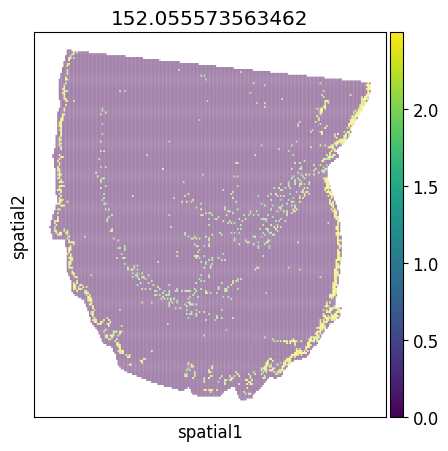

In [52]:
plot_gene = '152.055573563462'
fig, ax = plt.subplots(figsize=(5, 5))  # 例如，figsize=(10, 8) 表示宽度为
plt.rcParams['font.size'] = 12  # 假设默认字体大小是10
sc.pl.embedding(new_adata, basis="spatial",color=plot_gene, show=False,vmax='p99',ax=ax)

<Axes: title={'center': '152.055573563462'}, xlabel='spatial1', ylabel='spatial2'>

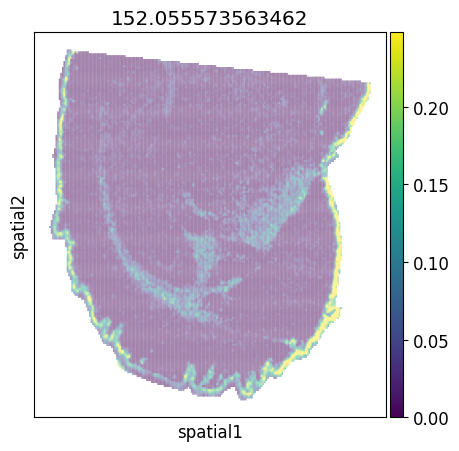

In [53]:
plot_gene = '152.055573563462'
fig, ax = plt.subplots(figsize=(5, 5))  # 例如，figsize=(10, 8) 表示宽度为
plt.rcParams['font.size'] = 12  # 假设默认字体大小是10
sc.pl.embedding(new_adata, basis="spatial", layer = 'SMGLED_ReX',color=plot_gene, show=False,vmax='p99',ax=ax)

<Axes: title={'center': '716.453819448202'}, xlabel='spatial1', ylabel='spatial2'>

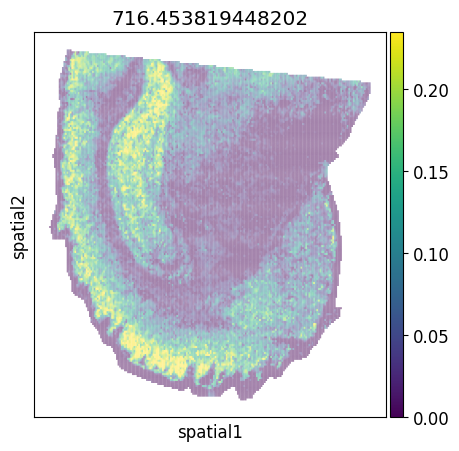

In [98]:
plot_gene = '716.453819448202'
fig, ax = plt.subplots(figsize=(5, 5))  # 例如，figsize=(10, 8) 表示宽度为
plt.rcParams['font.size'] = 12  # 假设默认字体大小是10
sc.pl.embedding(new_adata, basis="spatial", layer = 'SMGLED_ReX',color=plot_gene, show=False,vmax='p99',ax=ax)

<Axes: title={'center': '870.541344137682'}, xlabel='spatial1', ylabel='spatial2'>

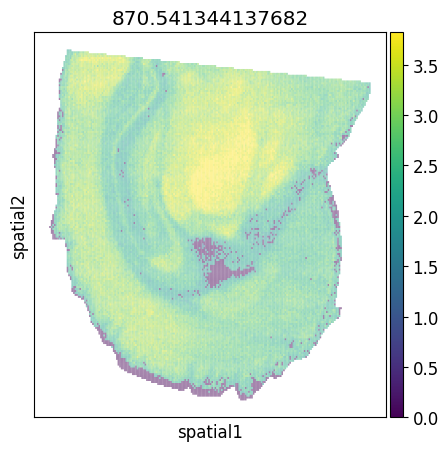

In [54]:
#new
plot_gene = '870.541344137682'#C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # width = 15, height = 5
plt.rcParams['font.size'] = 12  #  default font size is 10
sc.pl.embedding(new_adata, basis="spatial",color=plot_gene, show=False,vmax='p99',ax=ax)

<Axes: title={'center': '837.668742291891'}, xlabel='spatial1', ylabel='spatial2'>

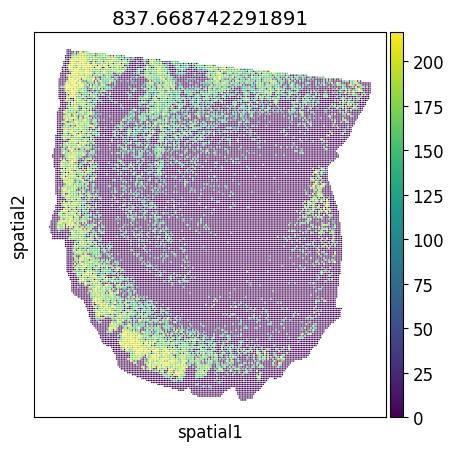

In [55]:
plot_gene = '837.668742291891'#C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # width = 15, height = 5
plt.rcParams['font.size'] = 12  #  default font size is 10
sc.pl.embedding(adata, basis="spatial",color=plot_gene, show=False,vmax='p99',ax=ax)

<Axes: title={'center': '837.668742291891'}, xlabel='spatial1', ylabel='spatial2'>

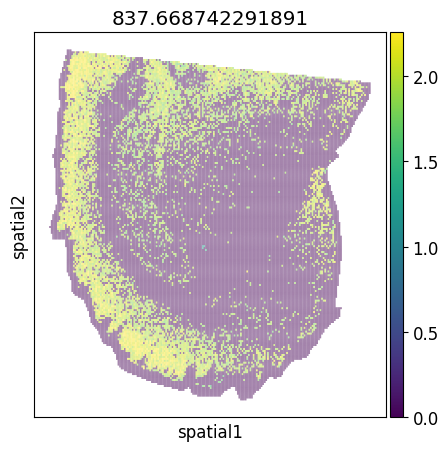

In [56]:
#837.518275761873, 837.613731334325, 837.668742291891
plot_gene = '837.668742291891'#C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # width = 15, height = 5
plt.rcParams['font.size'] = 12  #  default font size is 10
sc.pl.embedding(new_adata, basis="spatial",color=plot_gene, show=False,vmax='p99',ax=ax)

<Axes: title={'center': '837.668742291891'}, xlabel='spatial1', ylabel='spatial2'>

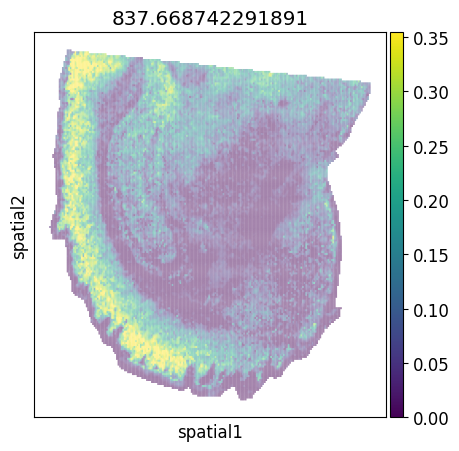

In [57]:
#837.518275761873, 837.613731334325, 837.668742291891
plot_gene = '837.668742291891'#C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # width = 15, height = 5
plt.rcParams['font.size'] = 12  #  default font size is 10
sc.pl.embedding(new_adata, basis="spatial", layer = 'SMGLED_ReX',color=plot_gene, show=False,vmax='p99',ax=ax)

<Axes: title={'center': '870.541344137682'}, xlabel='spatial1', ylabel='spatial2'>

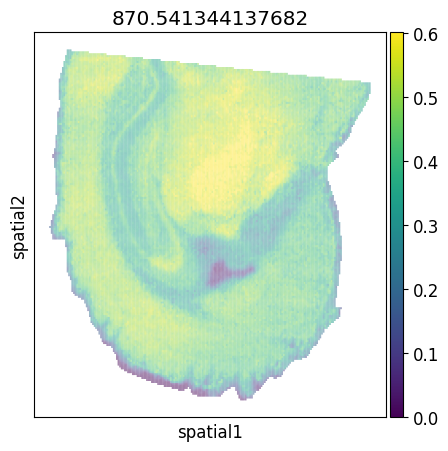

In [58]:
#870.467600862062, 870.541344137682, 870.583374955104, 871.469902086163, 871.543112350809, 872.486720495967, 872.554704124855, 873.488466147806
#new
plot_gene = '870.541344137682'#C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # width = 15, height = 5
plt.rcParams['font.size'] = 12  #  default font size is 10
sc.pl.embedding(new_adata, basis="spatial", layer = 'SMGLED_ReX',color=plot_gene, show=False,vmax='p99',ax=ax)

<Axes: title={'center': '874.496450812922'}, xlabel='spatial1', ylabel='spatial2'>

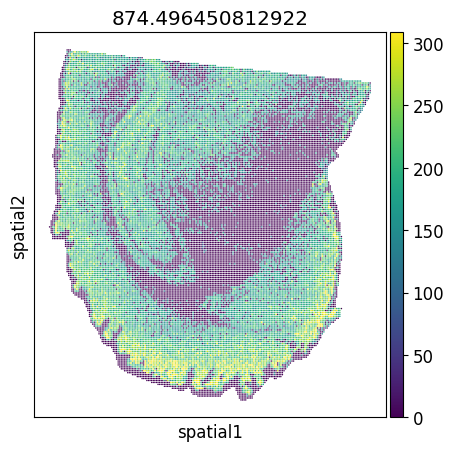

In [107]:
# 870.467600862062, 870.541344137682, 870.583374955104, 871.469902086163, 871.543112350809, 872.486720495967, 872.554704124855, 873.488466147806, 873.558718291921, 874.496450812922, 874.563403341796, 875.500361908053, 875.56528305726, 876.503580966052, 876.585264291746, 877.507149500935, 877.587492237133, 878.512685346411, 878.579230678122, 879.577704295084
plot_gene = '874.496450812922'#C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # width = 15, height = 5
plt.rcParams['font.size'] = 12  #  default font size is 10
sc.pl.embedding(adata, basis="spatial",color=plot_gene, show=False,vmax='p99',ax=ax)

<Axes: title={'center': '874.496450812922'}, xlabel='spatial1', ylabel='spatial2'>

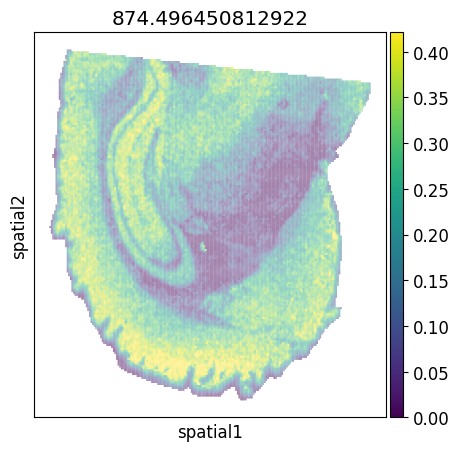

In [108]:
# 891.714052867923, 892.52277446081, 892.717081619993, 893.524865888267, 894.526298099232, 896.478528098035, 896.545589706428, 896.598629915757, 897.4818903434, 897.602291398602, 898.480896571908, 898.568027999562, 899.572791700219
plot_gene = '874.496450812922'#C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # width = 15, height = 5
plt.rcParams['font.size'] = 12  #  default font size is 10
sc.pl.embedding(new_adata, basis="spatial", layer = 'SMGLED_ReX',color=plot_gene, show=False,vmax='p99',ax=ax)

In [59]:
new_adata

AnnData object with n_obs × n_vars = 110164 × 1389
    obs: 'array_row', 'array_col', 'x', 'y'
    uns: 'log1p', 'Spatial_Net'
    obsm: 'spatial', 'STMGraph'
    layers: 'SMGLED_ReX'

<Axes: title={'center': '851.563432293921'}, xlabel='spatial1', ylabel='spatial2'>

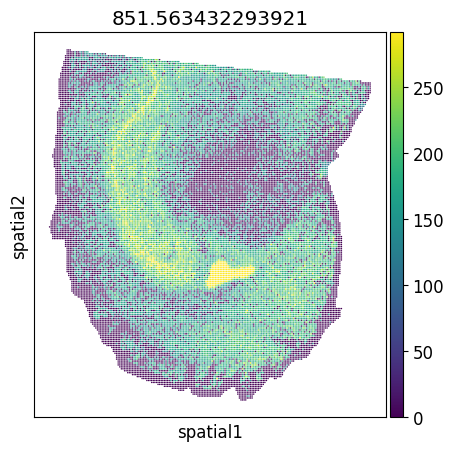

In [60]:
# 851.488705687729, 851.563432293921, 851.639596443398
plot_gene = '851.563432293921'#C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # width = 15, height = 5
plt.rcParams['font.size'] = 12  #  default font size is 10
sc.pl.embedding(adata, basis="spatial", color=plot_gene, show=False,vmax='p99',ax=ax)

<Axes: title={'center': '851.563432293921'}, xlabel='spatial1', ylabel='spatial2'>

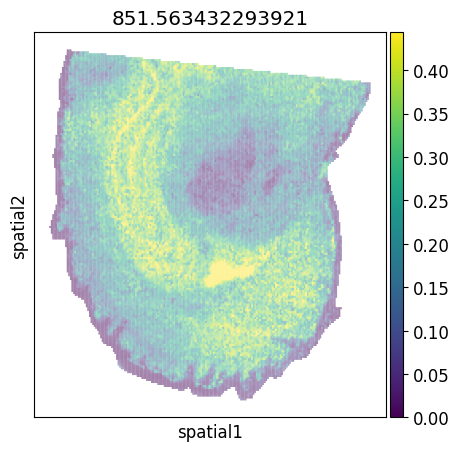

In [61]:
# 851.488705687729, 851.563432293921, 851.639596443398
plot_gene = '851.563432293921'#C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # width = 15, height = 5
plt.rcParams['font.size'] = 12  #  default font size is 10
sc.pl.embedding(new_adata, basis="spatial", layer = 'SMGLED_ReX',color=plot_gene, show=False,vmax='p99',ax=ax)

<Axes: title={'center': '870.467600862062'}, xlabel='spatial1', ylabel='spatial2'>

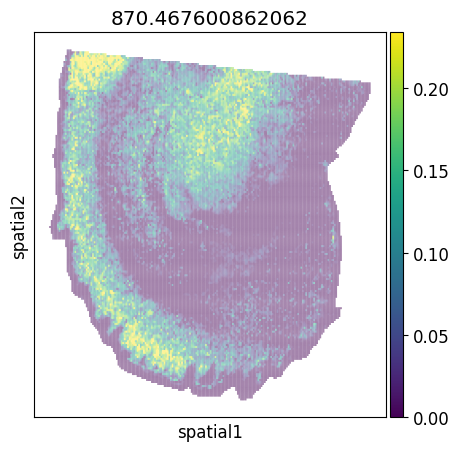

In [62]:
plot_gene = '870.467600862062'#C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # width = 15, height = 5
plt.rcParams['font.size'] = 12  #  default font size is 10
sc.pl.embedding(new_adata, basis="spatial", layer = 'SMGLED_ReX',color=plot_gene, show=False,vmax='p99',ax=ax)

In [63]:
adata_REX = anndata_transfer_resolution2(adata=adata,pixel_size=30)
adata_REX.X=new_adata.layers['SMGLED_ReX']

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [64]:
import squidpy as sq
sq.gr.spatial_neighbors(adata_REX)
sq.gr.spatial_autocorr(adata_REX, mode="moran", genes=adata_REX.var_names)
sq.gr.spatial_autocorr(adata_REX, mode="geary", genes=adata_REX.var_names)

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/metrics/_gearys_c.py:295: UserWarning: 18 variables were constant, will return nan for these.
  warnings.warn(
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/metrics/_gearys_c.py:295: UserWarning: 18 variables were constant, will return nan for these.
  warnings.warn(


In [65]:
adata_SMLED_high_moran_genes = adata_REX.uns['moranI']['I'][(adata_REX.uns['moranI']['I'] > 0.5) & (adata_REX.uns['moranI']['pval_norm'] < 0.05)].index.tolist()
adata_SMLED_high_moran = adata_REX[:, adata_SMLED_high_moran_genes]

adata_SMLED_high_geary_genes = adata_REX.uns['gearyC']['C'][(adata_REX.uns['gearyC']['C'] < 0.5) & (adata_REX.uns['gearyC']['pval_norm'] < 0.05)].index.tolist()
adata_SMLED_high_geary = adata_REX[:, adata_SMLED_high_geary_genes]

In [66]:
adata_SMLED_set1 = set(adata_SMLED_high_geary.var_names)
adata_SMLED_set2 = set(adata_SMLED_high_moran.var_names)
adata_SMLED_v = adata_SMLED_set1&adata_SMLED_set2

In [67]:
import squidpy as sq
sq.gr.spatial_neighbors(adata)
sq.gr.spatial_autocorr(adata, mode="moran", genes=adata.var_names)
sq.gr.spatial_autocorr(adata, mode="geary", genes=adata.var_names)

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/metrics/_gearys_c.py:295: UserWarning: 221 variables were constant, will return nan for these.
  warnings.warn(
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/metrics/_gearys_c.py:295: UserWarning: 221 variables were constant, will return nan for these.
  warnings.warn(


In [68]:
adata_high_moran_genes = adata.uns['moranI']['I'][(adata.uns['moranI']['I'] > 0.5) & (adata.uns['moranI']['pval_norm'] < 0.05)].index.tolist()
adata_high_moran = adata[:, adata_high_moran_genes]

adata_high_geary_genes = adata.uns['gearyC']['C'][(adata.uns['gearyC']['C'] < 0.5) & (adata.uns['gearyC']['pval_norm'] < 0.05)].index.tolist()
adata_high_geary = adata[:, adata_high_geary_genes]

In [69]:
ms_adata_set1 = set(adata_high_geary.var_names)
ms_adata_set2 = set(adata_high_moran.var_names)
ms_adata_v = ms_adata_set1&ms_adata_set2

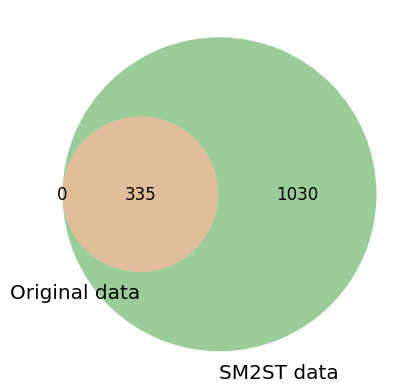

In [70]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# 定义两个集合
set1 = ms_adata_v
set2 = adata_SMLED_v

# 绘制韦恩图
venn = venn2([set1, set2], ('Original data', 'SM2ST data'))

# 设置标签显示交集和差集的数目
venn.get_label_by_id('100').set_text(f'{len(set1 - set2)}')
venn.get_label_by_id('010').set_text(f'{len(set2 - set1)}')
venn.get_label_by_id('110').set_text(f'{len(set1 & set2)}')

# 显示图形
plt.show()

In [71]:
set1-set2

set()

<Axes: title={'center': '723.493104258854'}, xlabel='spatial1', ylabel='spatial2'>

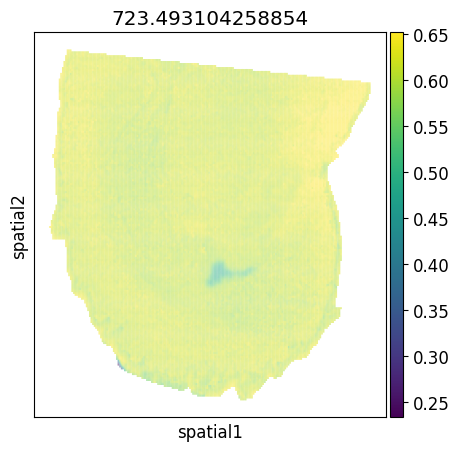

In [72]:
#870.467600862062, 870.541344137682, 870.583374955104, 871.469902086163, 871.543112350809, 872.486720495967, 872.554704124855, 873.488466147806
#new
plot_gene = '723.493104258854'#C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # width = 15, height = 5
plt.rcParams['font.size'] = 12  #  default font size is 10
sc.pl.embedding(adata_REX, basis="spatial",color=plot_gene, show=False,vmax='p99',ax=ax)

<Axes: title={'center': '723.493104258854'}, xlabel='spatial1', ylabel='spatial2'>

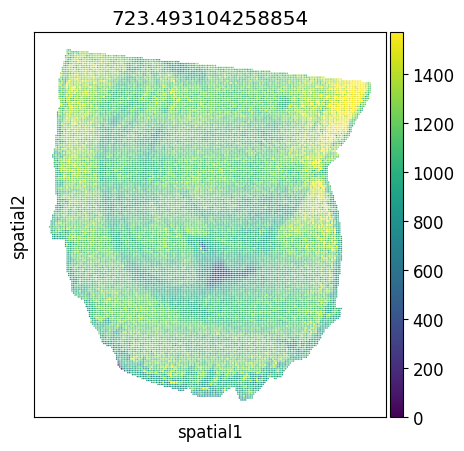

In [73]:
#870.467600862062, 870.541344137682, 870.583374955104, 871.469902086163, 871.543112350809, 872.486720495967, 872.554704124855, 873.488466147806
#new
plot_gene = '723.493104258854'#C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # width = 15, height = 5
plt.rcParams['font.size'] = 12  #  default font size is 10
sc.pl.embedding(adata, basis="spatial",color=plot_gene, show=False,vmax='p99',ax=ax)

In [74]:
# new_adata.write_h5ad('/public/home/stu_wanghaoyu/project/1_pyg/Data/MSD/adata_pen_masked_fill2.h5ad')
# new_adata = sc.read_h5ad('/public/home/stu_wanghaoyu/project/1_pyg/Data/MSD/adata_pen_masked_fill2.h5ad')

In [75]:
# adata_REX = sc.read_h5ad('/home/llx/project/jupyternotebook/1_pyg_backup/SMLED_pyG_result/adata_STMGrpah_ito_30um_mad_rex.h5ad')

In [76]:
adata_REX

AnnData object with n_obs × n_vars = 110164 × 1389
    obs: 'array_row', 'array_col'
    uns: 'spatial_neighbors', 'moranI', 'gearyC'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [77]:
adata_REX_h = adata_REX.copy()  # 创建一个副本
# sc.pp.highly_variable_genes(adata_REX_h, flavor="seurat_v3", n_top_genes=300)
# sc.pp.normalize_total(adata_REX_h, target_sum=1e4)
# sc.pp.log1p(adata_REX_h)
# adata_REX_h = adata_REX_h[:, adata_REX_h.var['highly_variable']]

In [78]:
# STMGraph.Cal_Spatial_Net(adata_REX, k_cutoff=8, model='KNN')
# STMGraph.Stats_Spatial_Net(adata_REX)
# adata_REX = STMGraph.train_STMGraph(adata_REX, mask_ratio=0.5,noise=0.05, alpha=1, n_epochs=1000, save_reconstrction=True)

In [79]:
# grid setting
num_batch_x = 3
num_batch_y = 2
adata_REX_h = adata_REX_h.copy()  # 将视图转换为副本
adata_REX_h.obs['x'] = adata_REX_h.obsm['spatial'][:,0]
adata_REX_h.obs['y'] = adata_REX_h.obsm['spatial'][:,1]

In [80]:
adata_REX_h.obs

array_row  array_col     x     y
0             121          1  3630    30
1             122          1  3660    30
2             123          1  3690    30
3             124          1  3720    30
4             120          2  3600    60
...           ...        ...   ...   ...
110159         49        361   735  5415
110160         51        361   765  5415
110161         25        363   375  5445
110162         27        363   405  5445
110163         29        363   435  5445

[110164 rows x 4 columns]

In [81]:
import seaborn as sns
def Batch_Data(adata, num_batch_x, num_batch_y, spatial_key=['X', 'Y'], plot_Stats=False):
    Sp_df = adata.obs.loc[:, spatial_key].copy()
    Sp_df = np.array(Sp_df)
    batch_x_coor_1 = [np.percentile(Sp_df[:, 0], (1/num_batch_x)*x*100) for x in range(num_batch_x+1)]
    batch_y_coor_1 = [np.percentile(Sp_df[:, 1], (1/num_batch_y)*x*100) for x in range(num_batch_y+1)]
    batch_x_coor_2 = [np.percentile(Sp_df[:, 0], (1/(num_batch_x*2))*x*100) for x in range(1,num_batch_x*2+1,2)]
    batch_y_coor_2 = [np.percentile(Sp_df[:, 1], (1/(num_batch_y*2))*x*100) for x in range(1,num_batch_y*2+1,2)]
    
    Batch_list = []
    for it_x in range(num_batch_x):
        for it_y in range(num_batch_y):
            min_x_1 = batch_x_coor_1[it_x]
            max_x_1 = batch_x_coor_1[it_x+1]
            min_y_1 = batch_y_coor_1[it_y]
            max_y_1 = batch_y_coor_1[it_y+1]
            temp_adata = adata.copy()
            temp_adata = temp_adata[temp_adata.obs[spatial_key[0]].map(lambda x: min_x_1 <= x <= max_x_1)]
            temp_adata = temp_adata[temp_adata.obs[spatial_key[1]].map(lambda y: min_y_1 <= y <= max_y_1)]
            Batch_list.append(temp_adata)
    
    for it_x in range(num_batch_x-1):
        for it_y in range(num_batch_y-1):
            min_x_2 = batch_x_coor_2[it_x]
            max_x_2 = batch_x_coor_2[it_x+1]
            min_y_2 = batch_y_coor_2[it_y]
            max_y_2 = batch_y_coor_2[it_y+1]
            temp_adata = adata.copy()
            temp_adata = temp_adata[temp_adata.obs[spatial_key[0]].map(lambda x: min_x_2 <= x <= max_x_2)]
            temp_adata = temp_adata[temp_adata.obs[spatial_key[1]].map(lambda y: min_y_2 <= y <= max_y_2)]
            Batch_list.append(temp_adata)
    
    for it_x in range(num_batch_x-1):
        for it_y in range(num_batch_y):
            min_x_2 = batch_x_coor_2[it_x]
            max_x_2 = batch_x_coor_2[it_x+1]
            min_y_1 = batch_y_coor_1[it_y]
            max_y_1 = batch_y_coor_1[it_y+1]
            temp_adata = adata.copy()
            temp_adata = temp_adata[temp_adata.obs[spatial_key[0]].map(lambda x: min_x_2 <= x <= max_x_2)]
            temp_adata = temp_adata[temp_adata.obs[spatial_key[1]].map(lambda y: min_y_1 <= y <= max_y_1)]
            Batch_list.append(temp_adata)
    
    for it_x in range(num_batch_x):
        for it_y in range(num_batch_y-1):
            min_x_1 = batch_x_coor_1[it_x]
            max_x_1 = batch_x_coor_1[it_x+1]
            min_y_2 = batch_y_coor_2[it_y]
            max_y_2 = batch_y_coor_2[it_y+1]
            temp_adata = adata.copy()
            temp_adata = temp_adata[temp_adata.obs[spatial_key[0]].map(lambda x: min_x_1 <= x <= max_x_1)]
            temp_adata = temp_adata[temp_adata.obs[spatial_key[1]].map(lambda y: min_y_2 <= y <= max_y_2)]
            Batch_list.append(temp_adata)
    if plot_Stats:
        f, ax = plt.subplots(figsize=(1, 3))
        plot_df = pd.DataFrame([x.shape[0] for x in Batch_list], columns=['#spot/batch'])
        sns.boxplot(y='#spot/batch', data=plot_df, ax=ax)
        sns.stripplot(y='#spot/batch', data=plot_df, ax=ax, color='red', size=5)
    return Batch_list

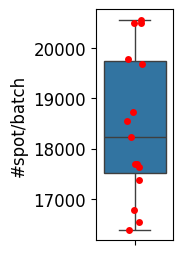

In [82]:
Batch_list_2 = Batch_Data(adata_REX_h, num_batch_x=num_batch_x, num_batch_y=num_batch_y,spatial_key=['x', 'y'], plot_Stats=True)

In [83]:
# Consturcting network for each batch
for temp_adata in Batch_list_2:
    STMGraph_pyG0.Cal_Spatial_Net(temp_adata, model='KNN', k_cutoff=8, delta_err=0.05)
    #STAGATE_pyG.Stats_Spatial_Net(temp_adata)

------Calculating spatial graph...
The graph contains 129306 edges, 16389 cells.
7.8898 neighbors per cell on average.


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


------Calculating spatial graph...
The graph contains 162700 edges, 20562 cells.
7.9127 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 162110 edges, 20498 cells.
7.9086 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 132710 edges, 16788 cells.
7.9051 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 147994 edges, 18733 cells.
7.9002 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 143994 edges, 18232 cells.
7.8979 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 139952 edges, 17696 cells.
7.9087 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 139952 edges, 17696 cells.
7.9087 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 155710 edges, 19688 cells.
7.9089 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 139458 edges, 17636 cells.
7.9076 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 162034 edges, 20486 cells.
7.9095 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 130798 edges, 16546 cells.
7.9051 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 156456 edges, 19778 cells.
7.9106 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 137436 edges, 17380 cells.
7.9077 neighbors per cell on average.
------Calculating spatial graph...


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


The graph contains 146516 edges, 18542 cells.
7.9018 neighbors per cell on average.


/home/llx/project/jupyternotebook/1_pyg_backup/STMGraph_pyG0/utils.py:112: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


In [84]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data_list2 = [STMGraph_pyG0.Transfer_pytorch_Data(temp_adata) for temp_adata in Batch_list_2]
for temp in data_list2:
    temp.to(device)

In [85]:
STMGraph_pyG0.Cal_Spatial_Net(adata_REX_h, model='KNN', k_cutoff=8, delta_err=0.05)
adata_om2 = STMGraph_pyG0.Transfer_pytorch_Data(adata_REX_h)

------Calculating spatial graph...
The graph contains 876748 edges, 110164 cells.
7.9586 neighbors per cell on average.


In [86]:
from torch_geometric.loader import DataLoader

# hyper-parameters
num_epoch = 1000
lr=0.001
weight_decay=1e-4
hidden_dims = [512, 30]
alpha = 1
mask_ratio = 0.5
noise = 0.0
gradient_clipping = 5.

import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm

def sce_loss(x, y, alpha=1.0):
    x = F.normalize(x, p=2, dim=-1)
    y = F.normalize(y, p=2, dim=-1)
    loss = (1 - (x * y).sum(dim=-1)).pow_(alpha)

    loss = loss.mean()
    return loss
seed=2025
fix_seed(seed)
# batch_size=1 or 2
loader = DataLoader(data_list2, batch_size=1, shuffle=True)
model = STMGraph_pyG0.STMGraph(hidden_dims = [data_list2[0].x.shape[1]]+hidden_dims).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
for epoch in tqdm(range(1, num_epoch+1)):
    for batch in loader:
        model.train()
        optimizer.zero_grad()
        # z, out = model(data.x, data.edge_index)
        z, out_1, out_2, mask_nodes, keep_nodes = model(batch.x, batch.edge_index, mask_rate=mask_ratio, replace_rate=noise)
        # loss = F.mse_loss(data.x, out_1)
        loss = sce_loss(batch.x[mask_nodes],out_1[mask_nodes],alpha=alpha) + sce_loss(batch.x[keep_nodes],out_2[keep_nodes],alpha=alpha)
        # loss = sce_loss(data.x,out_1,alpha=alpha) + sce_loss(data.x,out_2,alpha=alpha)
        # F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        # loss_list.append(loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
        optimizer.step()

100%|██████████| 1000/1000 [15:14<00:00,  1.09it/s]


In [87]:
# The total network
device_cpu = torch.device('cpu')
adata_om2.to(device_cpu)
model.to(device_cpu)

STMGraph(
  (encoding_mask_noise): encoding_mask_noise()
  (random_remask): random_remask()
  (conv1): GATv2Conv(1389, 512, heads=1)
  (conv2): GATv2Conv(512, 30, heads=1)
  (conv3): GATv2Conv(30, 512, heads=1)
  (conv4): GATv2Conv(512, 1389, heads=1)
)

In [88]:
model.eval()
z, out_1, out_2, mask_nodes, keep_nodes = model(adata_om2.x, adata_om2.edge_index, mask_rate=0, replace_rate=0)
STMGraph_rep = z.to('cpu').detach().numpy()
adata_REX_h.obsm['STMGraph'] = STMGraph_rep

In [89]:
# ReX = out_2.to('cpu').detach().numpy()
# ReX[ReX<0] = 0
# adata_REX.layers['STMGraph_ReX'] = ReX

In [90]:
adata_REX_h = STMGraph_pyG0.mclust_R(adata_REX_h, used_obsm='STMGraph', num_cluster=15)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'STMGraph'}, xlabel='spatial1', ylabel='spatial2'>

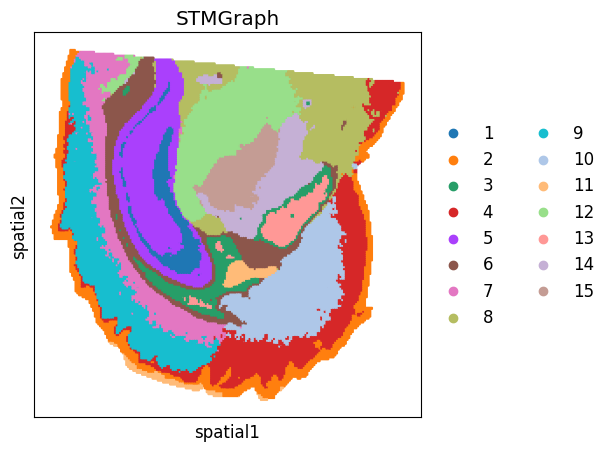

In [91]:
fig, ax = plt.subplots(figsize=(5, 5))  # 例如，figsize=(10, 8) 表示宽度为
sc.pl.embedding(adata_REX_h, basis="spatial", color="mclust",s=10, show=False, title='STMGraph', ax=ax)

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


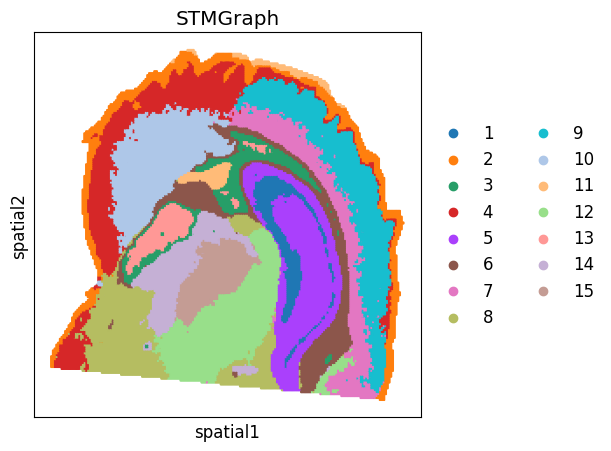

In [92]:
fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.embedding(adata_REX_h, basis="spatial", color="mclust", s=10, show=False, title='STMGraph', ax=ax)
ax.invert_xaxis()  # 反转 x 轴
ax.invert_yaxis()  # 反转 y 轴

In [95]:
# adata_REX.write_h5ad('/home/llx/project/jupyternotebook/1_pyg_backup/SMLED_pyG_result/adata_STMGrpah_ito_30um_mad_rex.h5ad')
# adata_REX = sc.read_h5ad('/home/llx/project/jupyternotebook/1_pyg_backup/SMLED_pyG_result/adata_STMGrpah_ito_30um_mad_rex.h5ad')

In [96]:
# adata_REX_h.write_h5ad('/home/llx/project/jupyternotebook/1_pyg_backup/SMLED_pyG_result/adata_STMGrpah_ito_30um_mad_rex_h.h5ad')